# Ajustes iniciales

## Conexión a drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#  !!!! ES NECESARIO EDITAR CON EL PATH CORRESPONDIENTE  !!!!
%cd drive/MyDrive/'Colab Notebooks/TTT-2020-1-16'

/content/drive/MyDrive/Colab Notebooks/TTT-2020-1-16


In [3]:
%pwd

'/content/drive/MyDrive/Colab Notebooks/TTT-2020-1-16'

## Importar los módulos *_utils

In [4]:
import sys
#  !!!! ES NECESARIO EDITAR CON EL PATH CORRESPONDIENTE  !!!!
sys.path.append('/content/drive/My Drive/Colab Notebooks/TTT-2020-1-16')
from my_utils import dataset_utils
from my_utils import eval_utils
from my_utils import nn_utils
from my_utils import results_utils

In [5]:
import pickle

# Funciones locales

## Prototipo de modelo

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout,SpatialDropout1D
from tensorflow import keras
from tensorflow.keras import layers

def convolutionalNetModel(task, params, optimizer, verbose = False):
  """
  Defines and compiles a new Keras model for a Convolutional Neural Network

  """

  SEQ_LENGTH = 55
  VEC_EMBEDDINGS_DIM = 300

  kernel_size_1, kernel_size_2, kernel_size_3 = params['kernels_combos']
  cnn_activation = params['conv_layers_activation']
  n_filters = params['n_filters']
  DL_1, DL_2 = params['dense_layers_sizes']
  spatial_dropout = params['spatial_dropout']
  dense_dropout = params['dense_dropout']

  embedding_sequences_input = keras.Input(name='INPUT', shape=(SEQ_LENGTH, VEC_EMBEDDINGS_DIM), dtype="float64")

  cnn_1 = layers.Conv1D(n_filters, kernel_size_1, activation=cnn_activation, name = 'CNN1')(embedding_sequences_input)
  cnn_1 = layers.SpatialDropout1D(spatial_dropout, name = 'SPATIAL_DROPOUT_1')(cnn_1)
  
  cnn_2 = layers.Conv1D(n_filters, kernel_size_2, activation=cnn_activation, name = 'CNN2')(embedding_sequences_input)
  cnn_2 = layers.SpatialDropout1D(spatial_dropout, name = 'SPATIAL_DROPOUT_2')(cnn_2)
  
  cnn_3 = layers.Conv1D(n_filters, kernel_size_3, activation=cnn_activation, name = 'CNN3')(embedding_sequences_input)
  cnn_3 = layers.SpatialDropout1D(spatial_dropout, name = 'SPATIAL_DROPOUT_3')(cnn_3)

  if params['pooling_method'] == 'max':
    cnn_1 = layers.GlobalMaxPooling1D(name = 'MAX_POOL_1')(cnn_1)
    cnn_2 = layers.GlobalMaxPooling1D(name = 'MAX_POOL_2')(cnn_2)
    cnn_3 = layers.GlobalMaxPooling1D(name = 'MAX_POOL_3')(cnn_3)
  elif params['pooling_method'] == 'average':
    cnn_1 = layers.GlobalAveragePooling1D(name = 'MAX_POOL_1')(cnn_1)
    cnn_2 = layers.GlobalAveragePooling1D(name = 'MAX_POOL_2')(cnn_2)
    cnn_3 = layers.GlobalAveragePooling1D(name = 'MAX_POOL_3')(cnn_3)

  fcnn = layers.Concatenate(axis=1, name = 'CONCATENATE')([cnn_1, cnn_2, cnn_3])
  fcnn = layers.Dense(DL_1, activation="relu", name = 'DL_1')(fcnn)
  fcnn = layers.Dropout(dense_dropout, name = 'DENSE_DROP_1')(fcnn)
  fcnn = layers.Dense(DL_2, activation="relu", name = 'DL_2')(fcnn)
  fcnn = layers.Dropout(dense_dropout, name = 'DENSE_DROP_2')(fcnn)

  if task in ['HS', 'TR', 'AG']:
    preds = layers.Dense(1, activation="sigmoid", name = 'PREDICTOR')(fcnn)
    model = keras.Model(embedding_sequences_input, preds)

    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["acc"])

  elif task == 'HTA':
    preds = layers.Dense(5, activation="softmax", name = 'PREDICTOR')(fcnn)
    preds = reshape = layers.Reshape(target_shape=(5,))(preds)

    model = keras.Model(embedding_sequences_input, preds)
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["acc"])

  if verbose:
    model.summary()

  return model

# Combinaciones de tamaños de kernel

## Dataset

In [ ]:
X_train, Y_train = dataset_utils.loadEncodedTrainData(embedding_type='FT3',
                                                 encoding_format='EMB-SEQ',
                                                 labels_to_return=['HTA'],
                                                 n_folds=7
                                                 )

## Espacio de búsqueda

**Parámetros de la arquitectura**

In [ ]:
from itertools import product

from itertools import combinations
from itertools import product

candidate_kernels = [1,2,3,4,5]
kernels_combos = list(combinations(candidate_kernels, 3))

dense_layers_sizes = [(300,100),
                      (200,100)]                    

arch_params = {'kernels_combos':kernels_combos,
              'dense_layers_sizes':dense_layers_sizes,
              'n_filters':[50,100,150],
              'conv_layers_activation':['tanh'],
              'pooling_method':['max'],
              'spatial_dropout':[0.5],
              'dense_dropout':[0.5]} 

arch_params_keys = arch_params.keys()

arch_params_combos = list(product( *arch_params.values() ))          

#arch_params_combos = [params_combo for params_combo in arch_params_combos if params_combo[-2]>=params_combo[-1]]
print('{} arch_params_combos.'.format(len(arch_params_combos)))   

60 arch_params_combos.


**Parámetros de la arquitectura**

In [ ]:
trainig_params_dict = {'optimizer':['adam-1e-3', 'rmsprop-1e-3'],
                       'batch_size':[512],
                       'max_epochs':[75]}

training_params_keys = trainig_params_dict.keys()
trainig_params_combos = list(product( *trainig_params_dict.values() ))

print('\n{} trainig_params_combos.'.format(len(trainig_params_combos))) 


2 trainig_params_combos.


In [ ]:
search_space = list(product(arch_params_combos, trainig_params_combos))

print('\n{} params combinations in the search_space.'.format(len(search_space))) 


120 params combinations in the search_space.


## Escaneo

In [ ]:
results_df = nn_utils.spaceScanner(X_train, Y_train,
                          'HTA',
                          convolutionalNetModel, 
                          search_space,
                          arch_params_keys,
                          training_params_keys,
                          fraction2eval=1,
                          n_folds=7,
                          fitting_attemps=1,
                          stop_threshold=1,
                          partial_CV=True,
                          backup_file='./Results/CNN/HTA/kernels_experiments.df',
                          backup_freq=5,
                          save_history_files=True,
                          save_models_as_json=False)

## Resultados

In [6]:
import pickle
from pandas import DataFrame

with open('./Results/CNN/HTA/kernels_experiments.df', 'rb') as file_handler:
  search_results = pickle.load(file_handler)

search_results.shape

(120, 19)

In [ ]:
from itertools import combinations
from itertools import product

candidate_kernels = [1,2,3,4,5]
kernels_combos = list(combinations(candidate_kernels, 3))

params_dict = {'kernels_combos':kernels_combos}

In [ ]:
search_results.sort_values(by='val_acc_A', ascending=False).head(5)

In [ ]:
search_results.sort_values(by='val_acc_B', ascending=False).head(10)

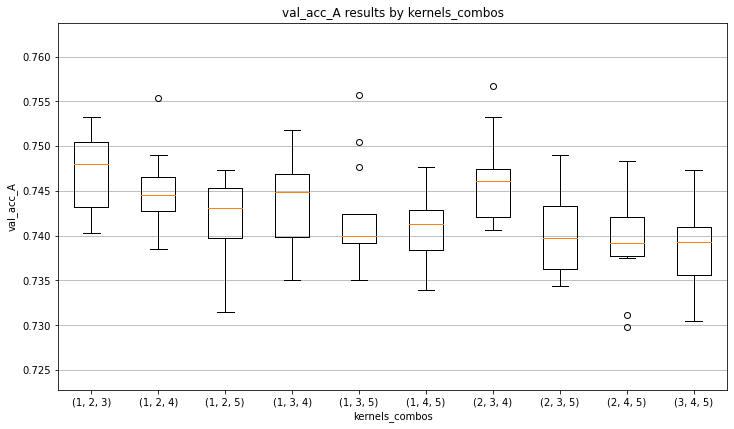

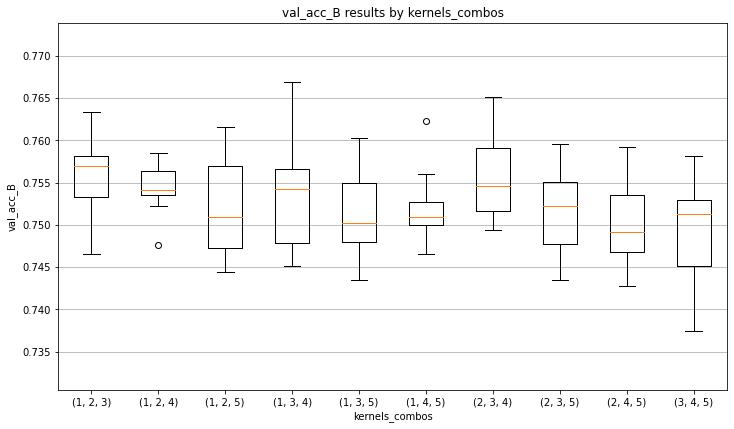

In [ ]:
results_utils.plotResultsByParameter1(search_results, 
                       params_dict, 
                       params2plot=['kernels_combos'],
                       metric='val_acc_A')

results_utils.plotResultsByParameter1(search_results, 
                       params_dict, 
                       params2plot=['kernels_combos'],
                       metric='val_acc_B')

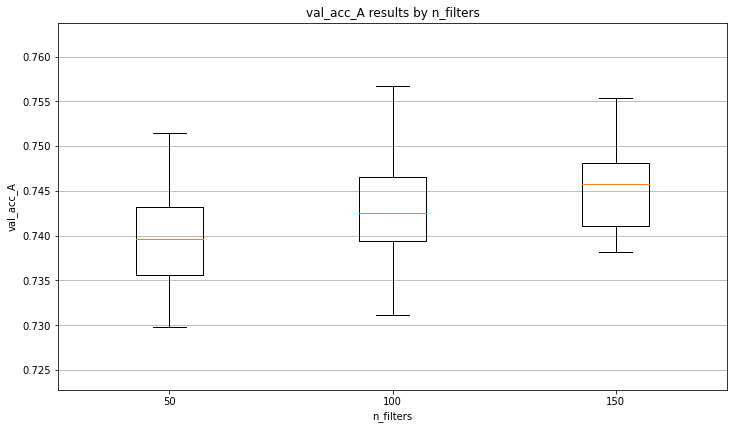

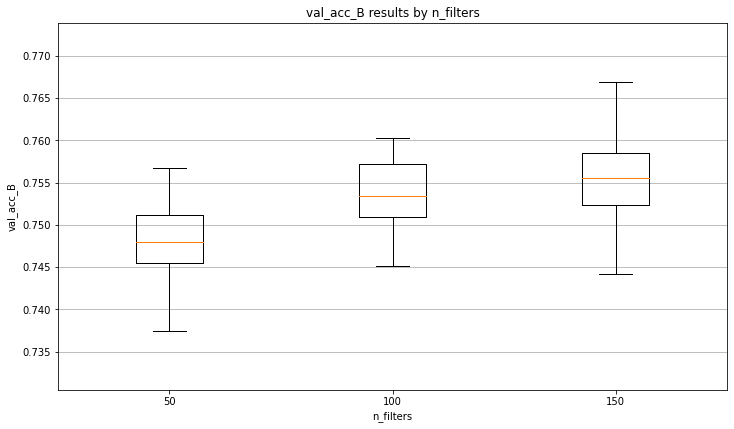

In [ ]:
params_dict = {'n_filters':[50,100,150]}

results_utils.plotResultsByParameter1(search_results, 
                       params_dict, 
                       params2plot=['n_filters'],
                       metric='val_acc_A')

results_utils.plotResultsByParameter1(search_results, 
                       params_dict, 
                       params2plot=['n_filters'],
                       metric='val_acc_B')

### Resumen de los resultados

* Mejores combinaciones de kernels sizes: (1,2,3), (2,3,4)
* lstm_units: [100,150]

# Experimentos con optimizadores

## Dataset

In [ ]:
X_train, Y_train = dataset_utils.loadEncodedTrainData(embedding_type='FT3',
                                                 encoding_format='EMB-SEQ',
                                                 labels_to_return=['HTA'],
                                                 n_folds=7
                                                 )

FastText 3 - Spanish Unannotated Corpora
Encoding Format: EMB-SEQ


## Espacio de búsqueda

**Parámetros de la arquitectura**

In [ ]:
from itertools import product

from itertools import combinations
from itertools import product

dense_layers_sizes = [(300,100),
                      (200,100)]                    

arch_params = {'kernels_combos':[(1,2,3),(2,3,4)],
              'dense_layers_sizes':dense_layers_sizes,
              'n_filters':[100,150,200],
              'conv_layers_activation':['tanh'],
              'pooling_method':['max'],
              'spatial_dropout':[0.5],
              'dense_dropout':[0.5]} 

arch_params_keys = arch_params.keys()

arch_params_combos = list(product( *arch_params.values() ))          

#arch_params_combos = [params_combo for params_combo in arch_params_combos if params_combo[-2]>=params_combo[-1]]
print('{} arch_params_combos.'.format(len(arch_params_combos)))   

12 arch_params_combos.


**Parámetros de la arquitectura**

In [ ]:
trainig_params_dict = {'optimizer':['adam-1e-3', 'adam-5e-4', 'adam-1e-4', 'rmsprop-1e-3', 'rmsprop-5e-4', 'rmsprop-1e-4'],
                       'batch_size':[512],
                       'max_epochs':[75]}
                        

training_params_keys = trainig_params_dict.keys()
trainig_params_combos = list(product( *trainig_params_dict.values() ))

print('\n{} trainig_params_combos.'.format(len(trainig_params_combos))) 


6 trainig_params_combos.


In [ ]:
search_space = list(product(arch_params_combos, trainig_params_combos))

print('\n{} params combinations in the search_space.'.format(len(search_space))) 


72 params combinations in the search_space.


## Escaneo

In [ ]:
results_df = nn_utils.spaceScanner(X_train, Y_train,
                          'HTA',
                          convolutionalNetModel, 
                          search_space,
                          arch_params_keys,
                          training_params_keys,
                          fraction2eval=1,
                          n_folds=7,
                          fitting_attemps=1,
                          stop_threshold=1,
                          partial_CV=True,
                          backup_file='./Results/CNN/HTA/experiments_1.df',
                          backup_freq=5,
                          save_history_files=True,
                          save_models_as_json=False)

## Resultados

In [7]:
import pickle
from pandas import DataFrame

with open('./Results/CNN/HTA/experiments_1.df', 'rb') as file_handler:
  search_results = pickle.load(file_handler)

search_results.shape

(72, 18)

In [ ]:
search_results.sort_values(by='val_acc_A', ascending=False).head(10)

,conf_ID,kernels_combos,dense_layers_sizes,n_filters,conv_layers_activation,pooling_method,spatial_dropout,dense_dropout,batch_size,optimizer,max_epochs,best_epochh,train_acc_A,val_acc_A,min2best,max2best,train_acc_B,val_acc_B
14,orvGiBoR,"(1, 2, 3)","(300, 100)",200,tanh,max,0.5,0.5,512,adam-1e-4,75,40,0.716385,0.763389,39,52,0.740009,0.767240
8,UpjLuMkO,"(1, 2, 3)","(300, 100)",150,tanh,max,0.5,0.5,512,adam-1e-4,75,50,0.735868,0.761289,40,50,0.717086,0.763039
26,MSAzjOPD,"(1, 2, 3)","(200, 100)",150,tanh,max,0.5,0.5,512,adam-1e-4,75,72,0.796302,0.760942,46,71,0.744793,0.766190
16,QHDLZheT,"(1, 2, 3)","(300, 100)",200,tanh,max,0.5,0.5,512,rmsprop-5e-4,75,35,0.803127,0.759195,26,35,0.765733,0.763044
43,AhOCGFJK,"(2, 3, 4)","(300, 100)",150,tanh,max,0.5,0.5,512,adam-5e-4,75,11,0.744560,0.758835,11,17,0.772208,0.762687
20,yOFEggQK,"(1, 2, 3)","(200, 100)",100,tanh,max,0.5,0.5,512,adam-1e-4,75,69,0.756692,0.758490,58,69,0.737910,0.762690
28,fEnXVcVo,"(1, 2, 3)","(200, 100)",150,tanh,max,0.5,0.5,512,rmsprop-5e-4,75,27,0.720410,0.757792,24,32,0.721637,0.764441
19,oWmfyZnT,"(1, 2, 3)","(200, 100)",100,tanh,max,0.5,0.5,512,adam-5e-4,75,15,0.739893,0.757089,12,16,0.725078,0.765488
31,azrfjcjn,"(1, 2, 3)","(200, 100)",200,tanh,max,0.5,0.5,512,adam-5e-4,75,13,0.737385,0.757089,10,13,0.721403,0.758490
7,sukSPbjW,"(1, 2, 3)","(300, 100)",150,tanh,max,0.5,0.5,512,adam-5e-4,75,12,0.732427,0.756738,12,13,0.738785,0.758139


In [ ]:
search_results.sort_values(by='val_acc_B', ascending=False).head(10)

,conf_ID,kernels_combos,dense_layers_sizes,n_filters,conv_layers_activation,pooling_method,spatial_dropout,dense_dropout,batch_size,optimizer,max_epochs,best_epochh,train_acc_A,val_acc_A,min2best,max2best,train_acc_B,val_acc_B
14,orvGiBoR,"(1, 2, 3)","(300, 100)",200,tanh,max,0.5,0.5,512,adam-1e-4,75,40,0.716385,0.763389,39,52,0.740009,0.767240
45,WNGSqxbP,"(2, 3, 4)","(300, 100)",150,tanh,max,0.5,0.5,512,rmsprop-1e-3,75,20,0.771276,0.744500,13,31,0.782415,0.766891
26,MSAzjOPD,"(1, 2, 3)","(200, 100)",150,tanh,max,0.5,0.5,512,adam-1e-4,75,72,0.796302,0.760942,46,71,0.744793,0.766190
19,oWmfyZnT,"(1, 2, 3)","(200, 100)",100,tanh,max,0.5,0.5,512,adam-5e-4,75,15,0.739893,0.757089,12,16,0.725078,0.765488
27,IYiqdbjm,"(1, 2, 3)","(200, 100)",150,tanh,max,0.5,0.5,512,rmsprop-1e-3,75,17,0.706118,0.749392,18,24,0.750450,0.764789
69,cuxSIuPF,"(2, 3, 4)","(200, 100)",200,tanh,max,0.5,0.5,512,rmsprop-1e-3,75,22,0.787319,0.753942,22,28,0.787086,0.764443
28,fEnXVcVo,"(1, 2, 3)","(200, 100)",150,tanh,max,0.5,0.5,512,rmsprop-5e-4,75,27,0.720410,0.757792,24,32,0.721637,0.764441
16,QHDLZheT,"(1, 2, 3)","(300, 100)",200,tanh,max,0.5,0.5,512,rmsprop-5e-4,75,35,0.803127,0.759195,26,35,0.765733,0.763044
46,nYtyAynY,"(2, 3, 4)","(300, 100)",150,tanh,max,0.5,0.5,512,rmsprop-5e-4,75,42,0.890919,0.745535,22,51,0.812923,0.763042
8,UpjLuMkO,"(1, 2, 3)","(300, 100)",150,tanh,max,0.5,0.5,512,adam-1e-4,75,50,0.735868,0.761289,40,50,0.717086,0.763039


In [ ]:
params_dict = {'optimizer':['adam-1e-3', 'adam-5e-4', 'adam-1e-4', 
                            'rmsprop-1e-3', 'rmsprop-5e-4', 'rmsprop-1e-4']}

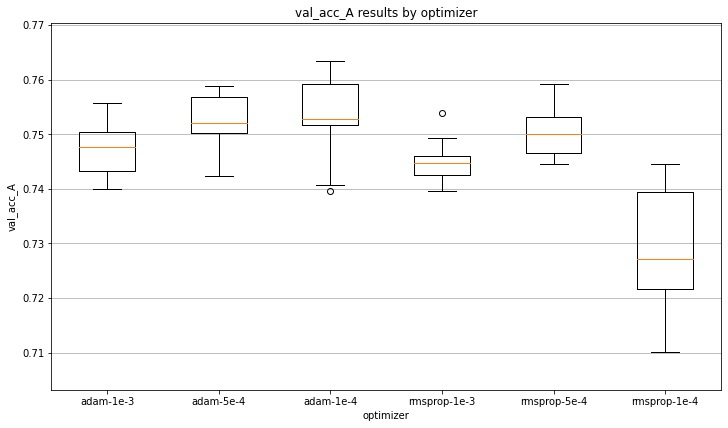

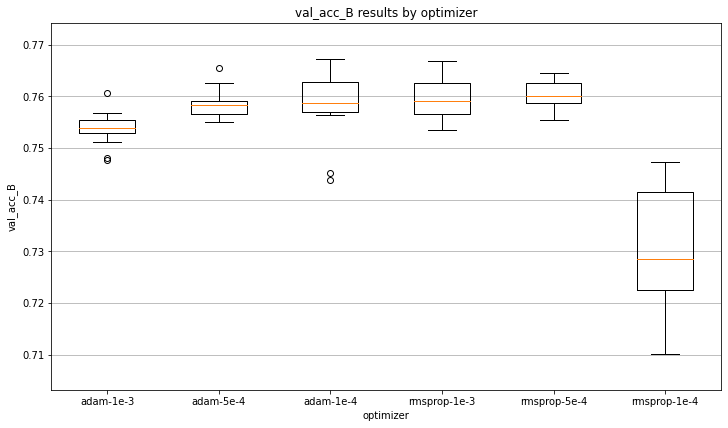

In [ ]:
results_utils.plotResultsByParameter1(search_results, 
                       params_dict, 
                       params2plot=['optimizer'],
                       metric='val_acc_A')

results_utils.plotResultsByParameter1(search_results, 
                       params_dict, 
                       params2plot=['optimizer'],
                       metric='val_acc_B')

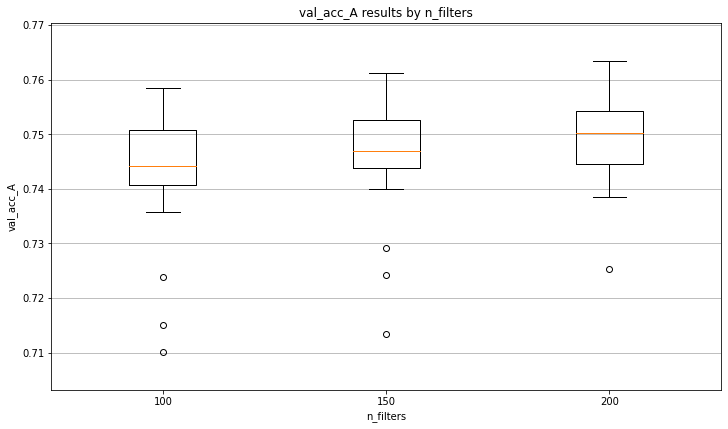

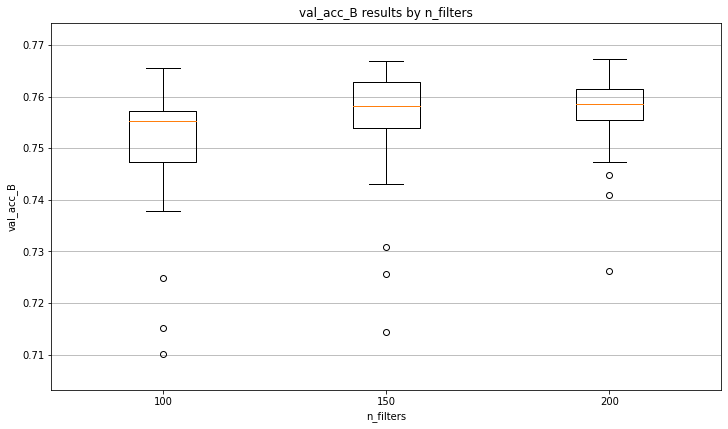

In [ ]:
params_dict = {'n_filters':[100,150,200]}

results_utils.plotResultsByParameter1(search_results, 
                       params_dict, 
                       params2plot=['n_filters'],
                       metric='val_acc_A')

results_utils.plotResultsByParameter1(search_results, 
                       params_dict, 
                       params2plot=['n_filters'],
                       metric='val_acc_B')

### Resumen de los resultados

* Mejores combinaciones de kernels sizes: (1,2,3), (2,3,4)
* lstm_units: [150,200]
* Optimizador: 'adam-1e-4', 'rmsprop-1e-3'

# Experimentos con el tamaño de las capas densas

## Dataset

In [ ]:
X_train, Y_train = dataset_utils.loadEncodedTrainData(embedding_type='FT3',
                                                 encoding_format='EMB-SEQ',
                                                 labels_to_return=['HTA'],
                                                 n_folds=7
                                                 )

FastText 3 - Spanish Unannotated Corpora
Encoding Format: EMB-SEQ

Process complete
5000 train instances retrieved

encodings_dim = (55, 300)


## Espacio de búsqueda

**Parámetros de la arquitectura**

In [ ]:
from itertools import product

from itertools import combinations
from itertools import product

dense_layers_sizes = [(400,100),
                      (400,75), 
                      (300,100),
                      (300,75),
                      (200,100),
                      (200,75)]                    

arch_params = {'kernels_combos':[(1,2,3),(2,3,4)],
              'dense_layers_sizes':dense_layers_sizes,
              'n_filters':[150,200],
              'conv_layers_activation':['tanh'],
              'pooling_method':['max'],
              'spatial_dropout':[0.5],
              'dense_dropout':[0.5]} 

arch_params_keys = arch_params.keys()

arch_params_combos = list(product( *arch_params.values() ))          

#arch_params_combos = [params_combo for params_combo in arch_params_combos if params_combo[-2]>=params_combo[-1]]
print('{} arch_params_combos.'.format(len(arch_params_combos)))   

24 arch_params_combos.


**Parámetros de la arquitectura**

In [ ]:
trainig_params_dict = {'optimizer':['adam-1e-4', 'rmsprop-1e-3'],
                       'batch_size':[512],
                       'max_epochs':[75]}
                        

training_params_keys = trainig_params_dict.keys()
trainig_params_combos = list(product( *trainig_params_dict.values() ))

print('\n{} trainig_params_combos.'.format(len(trainig_params_combos))) 


2 trainig_params_combos.


In [ ]:
search_space = list(product(arch_params_combos, trainig_params_combos))

print('\n{} params combinations in the search_space.'.format(len(search_space))) 


48 params combinations in the search_space.


## Escaneo

In [ ]:
results_df = nn_utils.spaceScanner(X_train, Y_train,
                          'HTA',
                          convolutionalNetModel, 
                          search_space,
                          arch_params_keys,
                          training_params_keys,
                          fraction2eval=1,
                          n_folds=7,
                          fitting_attemps=1,
                          stop_threshold=1,
                          partial_CV=True,
                          backup_file='./Results/CNN/HTA/experiments_2.df',
                          backup_freq=5,
                          save_history_files=True,
                          save_models_as_json=False)

## Resultados

In [8]:
import pickle
from pandas import DataFrame

with open('./Results/CNN/HTA/experiments_2.df', 'rb') as file_handler:
  search_results = pickle.load(file_handler)

search_results.shape

(48, 18)

In [ ]:
params_dict = {'dense_layers_sizes':[(400,100),
                      (400,75), 
                      (300,100),
                      (300,75),
                      (200,100),
                      (200,75)]}

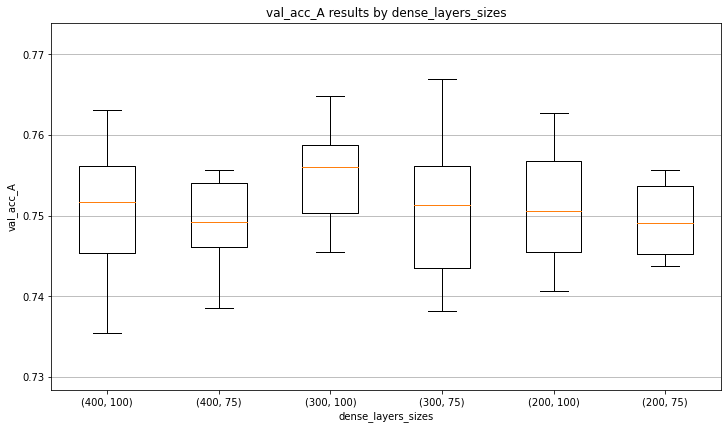

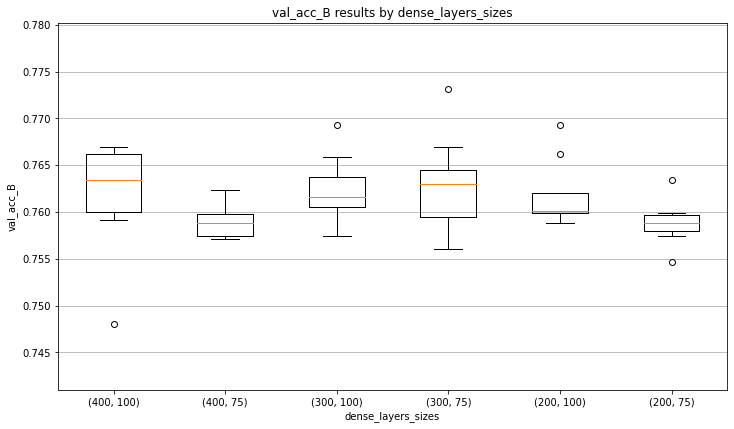

In [ ]:
results_utils.plotResultsByParameter1(search_results, 
                       params_dict, 
                       params2plot=['dense_layers_sizes'],
                       metric='val_acc_A')

results_utils.plotResultsByParameter1(search_results, 
                       params_dict, 
                       params2plot=['dense_layers_sizes'],
                       metric='val_acc_B')

### Resumen de los resultados

* Mejores combinaciones de kernels sizes: (1,2,3), (2,3,4)
* lstm_units: [150,200]
* dense_layers_sizes: [**(300,100)**], [**(400,100)**]

* Optimizador: 'adam-1e-4', 'rmsprop-1e-3'

# Experimentos con los valores de dropout

## Dataset

In [ ]:
X_train, Y_train = dataset_utils.loadEncodedTrainData(embedding_type='FT3',
                                                 encoding_format='EMB-SEQ',
                                                 labels_to_return=['HTA'],
                                                 n_folds=7
                                                 )

FastText 3 - Spanish Unannotated Corpora
Encoding Format: EMB-SEQ

Process complete
5000 train instances retrieved

encodings_dim = (55, 300)


## Espacio de búsqueda

**Parámetros de la arquitectura**

In [ ]:
from itertools import product

from itertools import combinations
from itertools import product

dense_layers_sizes = [(400,100), 
                      (300,100)]                    

arch_params = {'kernels_combos':[(1,2,3),(2,3,4)],
              'dense_layers_sizes':dense_layers_sizes,
              'n_filters':[175],
              'conv_layers_activation':['tanh'],
              'pooling_method':['max'],
              'spatial_dropout':[0.3,0.5,0.7],
              'dense_dropout':[0.3,0.5,0.7]} 

arch_params_keys = arch_params.keys()

arch_params_combos = list(product( *arch_params.values() ))          

#arch_params_combos = [params_combo for params_combo in arch_params_combos if params_combo[-2]>=params_combo[-1]]
print('{} arch_params_combos.'.format(len(arch_params_combos)))   

36 arch_params_combos.


**Parámetros de la arquitectura**

In [ ]:
trainig_params_dict = {'optimizer':['adam-1e-4', 'rmsprop-1e-3'],
                       'batch_size':[512],
                       'max_epochs':[75]}
                        

training_params_keys = trainig_params_dict.keys()
trainig_params_combos = list(product( *trainig_params_dict.values() ))

print('\n{} trainig_params_combos.'.format(len(trainig_params_combos))) 


2 trainig_params_combos.


In [ ]:
search_space = list(product(arch_params_combos, trainig_params_combos))

print('\n{} params combinations in the search_space.'.format(len(search_space))) 


48 params combinations in the search_space.


## Escaneo

In [ ]:
results_df = nn_utils.spaceScanner(X_train, Y_train,
                          'HTA',
                          convolutionalNetModel, 
                          search_space,
                          arch_params_keys,
                          training_params_keys,
                          fraction2eval=1,
                          n_folds=7,
                          fitting_attemps=1,
                          stop_threshold=1,
                          partial_CV=True,
                          backup_file='./Results/CNN/HTA/experiments_3.df',
                          backup_freq=5,
                          save_history_files=True,
                          save_models_as_json=False)

## Resultados

In [9]:
import pickle
from pandas import DataFrame

with open('./Results/CNN/HTA/experiments_3.df', 'rb') as file_handler:
  search_results = pickle.load(file_handler)

search_results.shape

(72, 18)

In [ ]:
search_results.sort_values(by='val_acc_A', ascending=False).head(10)

In [ ]:
search_results.sort_values(by='val_acc_B', ascending=False).head(10)

In [ ]:
params_dict = {'spatial_dropout':[0.3,0.5,0.7]}

results_utils.plotResultsByParameter1()

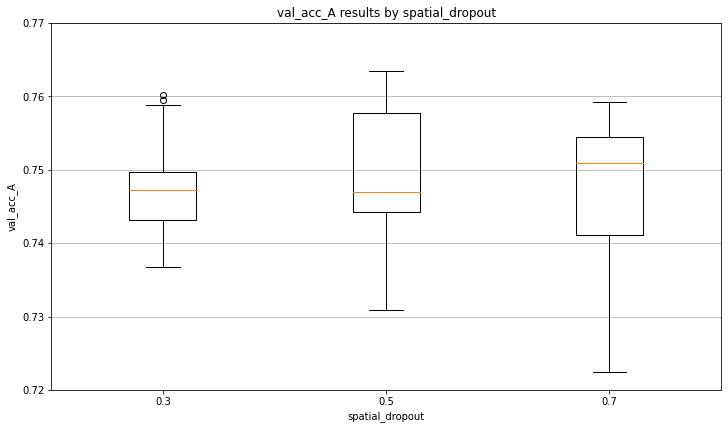

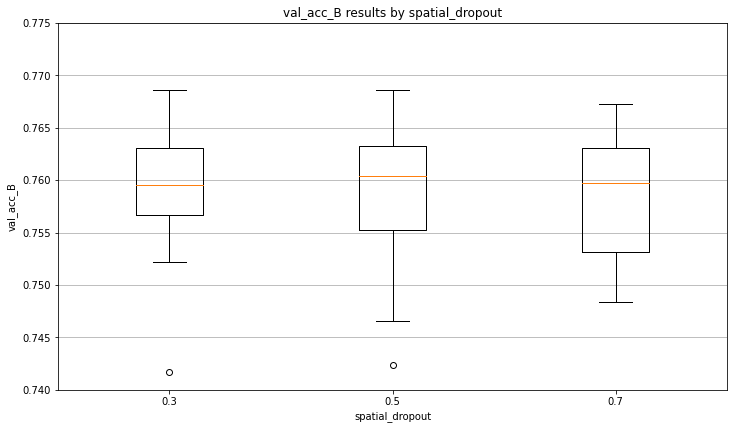

In [ ]:
results_utils.plotResultsByParameter1(search_results, 
                       params_dict, 
                       params2plot=['spatial_dropout'],
                       metric='val_acc_A',
                       y_limits=[0.72,0.77])

results_utils.plotResultsByParameter1(search_results, 
                       params_dict, 
                       params2plot=['spatial_dropout'],
                       metric='val_acc_B',
                       y_limits=[0.74,0.775])

In [ ]:
params_dict = {'dense_dropout':[0.3,0.5,0.7]}

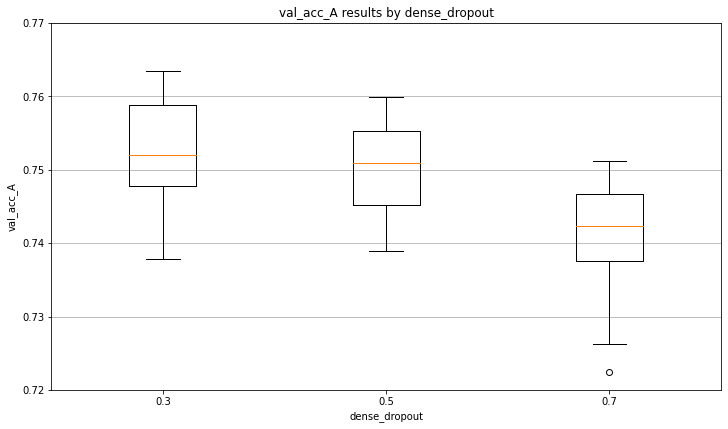

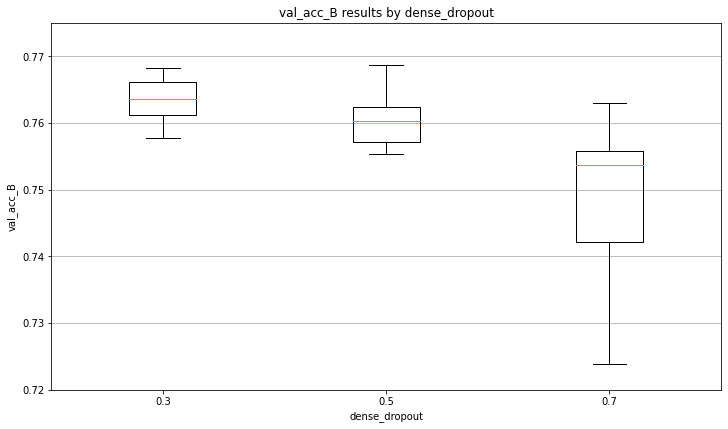

In [ ]:
results_utils.plotResultsByParameter1(search_results, 
                       params_dict, 
                       params2plot=['dense_dropout'],
                       metric='val_acc_A',
                       y_limits=[0.72,0.77])

results_utils.plotResultsByParameter1(search_results, 
                       params_dict, 
                       params2plot=['dense_dropout'],
                       metric='val_acc_B',
                       y_limits=[0.72,0.775])

### Resumen de los resultados

* combinaciones de kernels sizes: (1,2,3), (2,3,4)
* lstm_units: [150,200]
* dense_layers_sizes: [**(300,100)**, **(400,100)**]
* spatial_dropout: [0.3, **0.5**]
* dense_dropout:[**0.3**]
* Optimizador: 'adam-1e-4', 'rmsprop-1e-3'

# Experimentos con la función de activación y el pooling method

## Dataset

In [ ]:
X_train, Y_train = dataset_utils.loadEncodedTrainData(embedding_type='FT3',
                                                 encoding_format='EMB-SEQ',
                                                 labels_to_return=['HTA'],
                                                 n_folds=7
                                                 )

FastText 3 - Spanish Unannotated Corpora
Encoding Format: EMB-SEQ

Process complete
5000 train instances retrieved

encodings_dim = (55, 300)


## Espacio de búsqueda

**Parámetros de la arquitectura**

In [ ]:
from itertools import product

from itertools import combinations
from itertools import product

dense_layers_sizes = [(400,100), 
                      (300,100),
                      (300,75)]                    

arch_params = {'kernels_combos':[(1,2,3),(2,3,4)],
              'dense_layers_sizes':dense_layers_sizes,
              'n_filters':[175],
              'conv_layers_activation':['tanh','relu'],
              'pooling_method':['max','average'],
              'spatial_dropout':[0.5],
              'dense_dropout':[0.3]} 

arch_params_keys = arch_params.keys()

arch_params_combos = list(product( *arch_params.values() ))          

#arch_params_combos = [params_combo for params_combo in arch_params_combos if params_combo[-2]>=params_combo[-1]]
print('{} arch_params_combos.'.format(len(arch_params_combos)))   

24 arch_params_combos.


**Parámetros de la arquitectura**

In [ ]:
trainig_params_dict = {'optimizer':['adam-1e-4', 'rmsprop-1e-3'],
                       'batch_size':[512],
                       'max_epochs':[75]}

training_params_keys = trainig_params_dict.keys()
trainig_params_combos = list(product( *trainig_params_dict.values() ))

print('\n{} trainig_params_combos.'.format(len(trainig_params_combos))) 


2 trainig_params_combos.


In [ ]:
search_space = list(product(arch_params_combos, trainig_params_combos))

print('\n{} params combinations in the search_space.'.format(len(search_space))) 


48 params combinations in the search_space.


## Escaneo

In [11]:
results_df = nn_utils.spaceScanner(X_train, Y_train,
                          'HTA',
                          convolutionalNetModel, 
                          search_space,
                          arch_params_keys,
                          training_params_keys,
                          fraction2eval=1,
                          n_folds=7,
                          fitting_attemps=1,
                          stop_threshold=1,
                          partial_CV=True,
                          backup_file='./Results/CNN/HTA/experiments_4.df',
                          backup_freq=5,
                          save_history_files=True,
                          save_models_as_json=False)                          

## Resultados

In [12]:
import pickle
from pandas import DataFrame

with open('./Results/CNN/HTA/experiments_4.df', 'rb') as file_handler:
  search_results = pickle.load(file_handler)

search_results.shape

(48, 18)

In [ ]:
search_results.sort_values(by='val_acc_A', ascending=False).head(10)

,conf_ID,kernels_combos,dense_layers_sizes,n_filters,conv_layers_activation,pooling_method,spatial_dropout,dense_dropout,optimizer,batch_size,max_epochs,best_epochh,train_acc_A,val_acc_A,min2best,max2best,train_acc_B,val_acc_B
8,rKutsyHV,"(1, 2, 3)","(300, 100)",175,tanh,max,0.5,0.3,adam-1e-4,512,75,29,0.741176,0.765840,21,33,0.742285,0.775292
4,yHByibWT,"(1, 2, 3)","(400, 100)",175,relu,max,0.5,0.3,adam-1e-4,512,75,32,0.749052,0.764790,29,49,0.800564,0.770391
31,LlSEFSQr,"(2, 3, 4)","(400, 100)",175,relu,average,0.5,0.3,rmsprop-1e-3,512,75,43,0.789710,0.763392,32,63,0.801315,0.771091
20,UPCjrQtQ,"(1, 2, 3)","(300, 75)",175,relu,max,0.5,0.3,adam-1e-4,512,75,32,0.736043,0.761642,32,39,0.754536,0.766541
44,zouuGSpE,"(2, 3, 4)","(300, 75)",175,relu,max,0.5,0.3,adam-1e-4,512,75,26,0.759493,0.761290,19,35,0.766317,0.765842
12,XAWivNJl,"(1, 2, 3)","(300, 100)",175,relu,max,0.5,0.3,adam-1e-4,512,75,41,0.778859,0.759192,26,42,0.746194,0.764791
36,XViMFZGi,"(2, 3, 4)","(300, 100)",175,relu,max,0.5,0.3,adam-1e-4,512,75,29,0.786969,0.759189,25,29,0.772383,0.761639
32,gDlEprbs,"(2, 3, 4)","(300, 100)",175,tanh,max,0.5,0.3,adam-1e-4,512,75,29,0.809017,0.759184,23,34,0.789652,0.764787
16,oGAmLiMo,"(1, 2, 3)","(300, 75)",175,tanh,max,0.5,0.3,adam-1e-4,512,75,42,0.806043,0.758839,34,56,0.812517,0.764790
28,GCHDXlAs,"(2, 3, 4)","(400, 100)",175,relu,max,0.5,0.3,adam-1e-4,512,75,21,0.725952,0.757790,19,39,0.793566,0.760240


In [ ]:
search_results.sort_values(by='val_acc_B', ascending=False).head(10)

,conf_ID,kernels_combos,dense_layers_sizes,n_filters,conv_layers_activation,pooling_method,spatial_dropout,dense_dropout,optimizer,batch_size,max_epochs,best_epochh,train_acc_A,val_acc_A,min2best,max2best,train_acc_B,val_acc_B
8,rKutsyHV,"(1, 2, 3)","(300, 100)",175,tanh,max,0.5,0.3,adam-1e-4,512,75,29,0.741176,0.765840,21,33,0.742285,0.775292
7,eOVgQXTm,"(1, 2, 3)","(400, 100)",175,relu,average,0.5,0.3,rmsprop-1e-3,512,75,44,0.759026,0.757091,26,41,0.730793,0.773188
23,dBCyKXxC,"(1, 2, 3)","(300, 75)",175,relu,average,0.5,0.3,rmsprop-1e-3,512,75,44,0.750043,0.757086,34,50,0.736335,0.771440
0,QTVMzyGQ,"(1, 2, 3)","(400, 100)",175,tanh,max,0.5,0.3,adam-1e-4,512,75,73,0.873700,0.751833,31,69,0.749166,0.771439
31,LlSEFSQr,"(2, 3, 4)","(400, 100)",175,relu,average,0.5,0.3,rmsprop-1e-3,512,75,43,0.789710,0.763392,32,63,0.801315,0.771091
15,LRScJlJY,"(1, 2, 3)","(300, 100)",175,relu,average,0.5,0.3,rmsprop-1e-3,512,75,32,0.716326,0.756389,33,58,0.758616,0.770742
4,yHByibWT,"(1, 2, 3)","(400, 100)",175,relu,max,0.5,0.3,adam-1e-4,512,75,32,0.749052,0.764790,29,49,0.800564,0.770391
17,EApeajBq,"(1, 2, 3)","(300, 75)",175,tanh,max,0.5,0.3,rmsprop-1e-3,512,75,15,0.731669,0.749733,14,28,0.772033,0.770041
39,tNgmRPSV,"(2, 3, 4)","(300, 100)",175,relu,average,0.5,0.3,rmsprop-1e-3,512,75,51,0.804176,0.757443,23,44,0.743335,0.769341
47,cGZRqbor,"(2, 3, 4)","(300, 75)",175,relu,average,0.5,0.3,rmsprop-1e-3,512,75,45,0.776410,0.753589,28,54,0.742167,0.768641


In [ ]:
params_dict = {'conv_layers_activation':['tanh', 'relu']}

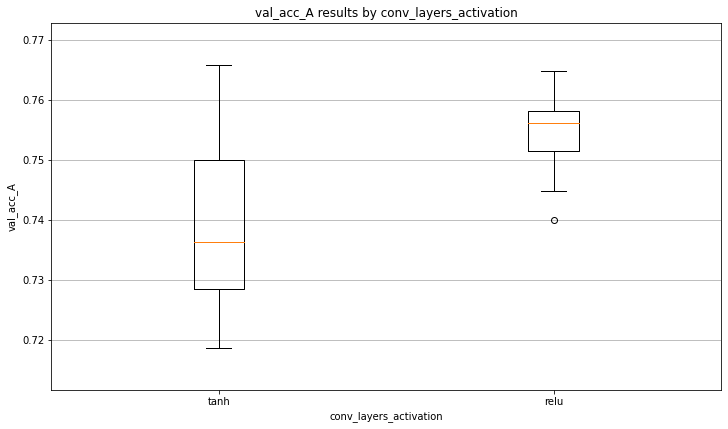

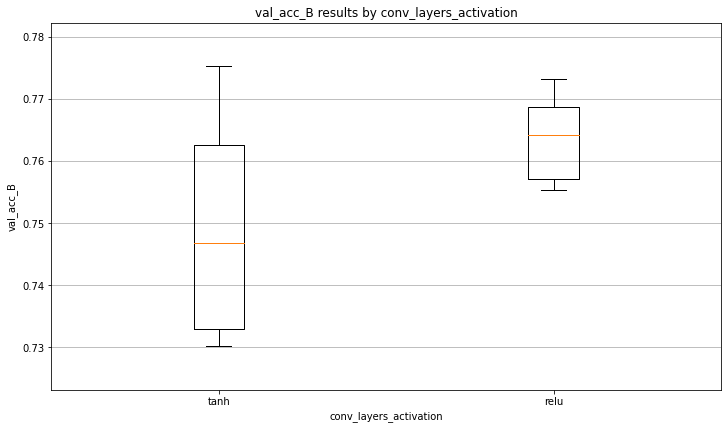

In [ ]:
results_utils.plotResultsByParameter1(search_results, 
                       params_dict, 
                       params2plot=['conv_layers_activation'],
                       metric='val_acc_A')

results_utils.plotResultsByParameter1(search_results, 
                       params_dict, 
                       params2plot=['conv_layers_activation'],
                       metric='val_acc_B')

In [ ]:
params_dict = {'pooling_method':['max', 'average']}

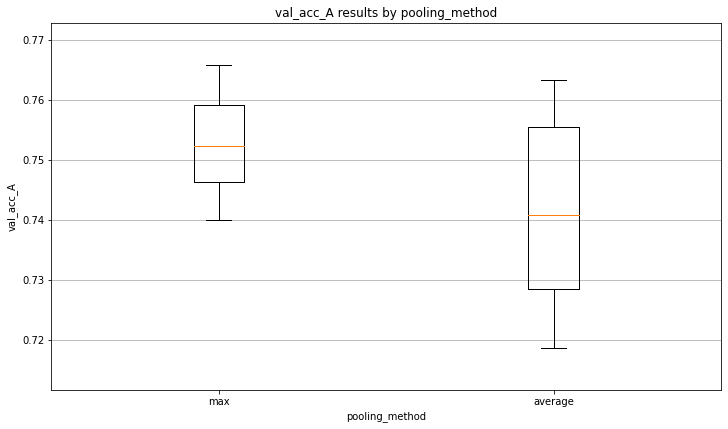

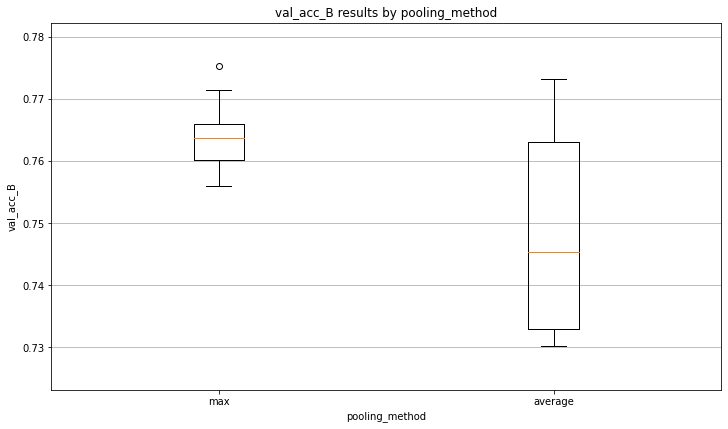

In [ ]:
results_utils.plotResultsByParameter1(search_results, 
                       params_dict, 
                       params2plot=['pooling_method'],
                       metric='val_acc_A')

results_utils.plotResultsByParameter1(search_results, 
                       params_dict, 
                       params2plot=['pooling_method'],
                       metric='val_acc_B')

### Resumen de los resultados

* combinaciones de kernels sizes: (1,2,3), (2,3,4)
* lstm_units: [150,200]
* dense_layers_sizes: [**(300,100)**, **(400,100)**]
* spatial_dropout: [0.3, **0.5**]
* dense_dropout:[**0.3**]

- Combinaciones (optimizador, cnn_activ, pooling)

  * 'adam-1e-4', 'tanh', 'max'
  * 'adam-1e-4', 'relu', 'max'
  * ''rmsprop-1e-3', 'relu', 'average'

# Experimentos con el batch_size

## Dataset

In [ ]:
X_train, Y_train = dataset_utils.loadEncodedTrainData(embedding_type='FT3',
                                                 encoding_format='EMB-SEQ',
                                                 labels_to_return=['HTA'],
                                                 n_folds=7
                                                 )

FastText 3 - Spanish Unannotated Corpora
Encoding Format: EMB-SEQ

Process complete
5000 train instances retrieved

encodings_dim = (55, 300)


## Espacio de búsqueda

**Parámetros de la arquitectura**

In [ ]:
from itertools import product

from itertools import combinations
from itertools import product

dense_layers_sizes = [(400,100),
                      (300,100)]                    

arch_params = {'kernels_combos':[(1,2,3),(2,3,4)],
              'dense_layers_sizes':dense_layers_sizes,
              'n_filters':[150,175,200],
              'conv_layers_activation':['tanh'],
              'pooling_method':['max'],
              'spatial_dropout':[0.5],
              'dense_dropout':[0.3]} 

arch_params_keys = arch_params.keys()

arch_params_combos = list(product( *arch_params.values() ))          

#arch_params_combos = [params_combo for params_combo in arch_params_combos if params_combo[-2]>=params_combo[-1]]
print('{} arch_params_combos.'.format(len(arch_params_combos)))   

12 arch_params_combos.


**Parámetros de la arquitectura**

In [ ]:
trainig_params_dict = {'optimizer':['adam-1e-4', 'rmsprop-1e-3'],
                       'batch_size':[256,512,1024],
                       'max_epochs':[75]}
                        

training_params_keys = trainig_params_dict.keys()
trainig_params_combos = list(product( *trainig_params_dict.values() ))

print('\n{} trainig_params_combos.'.format(len(trainig_params_combos))) 


6 trainig_params_combos.


In [ ]:
search_space = list(product(arch_params_combos, trainig_params_combos))

print('\n{} params combinations in the search_space.'.format(len(search_space))) 


96 params combinations in the search_space.


## Escaneo

In [ ]:
results_df = nn_utils.spaceScanner(X_train, Y_train,
                          'HTA',
                          convolutionalNetModel, 
                          search_space,
                          arch_params_keys,
                          training_params_keys,
                          fraction2eval=1,
                          n_folds=7,
                          fitting_attemps=1,
                          stop_threshold=1,
                          partial_CV=True,
                          backup_file='./Results/CNN/HTA/experiments_5.df',
                          backup_freq=5,
                          save_history_files=True,
                          save_models_as_json=False)

## Resultados

In [13]:
import pickle
from pandas import DataFrame

with open('./Results/CNN/HTA/experiments_5.df', 'rb') as file_handler:
  search_results = pickle.load(file_handler)

search_results.shape

(72, 18)

In [ ]:
search_results.sort_values(by='val_acc_A', ascending=False).head(10)

In [ ]:
search_results.sort_values(by='val_acc_B', ascending=False).head(10)

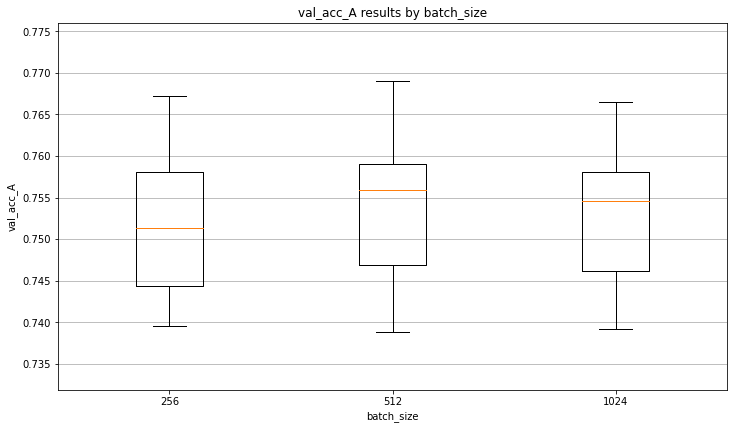

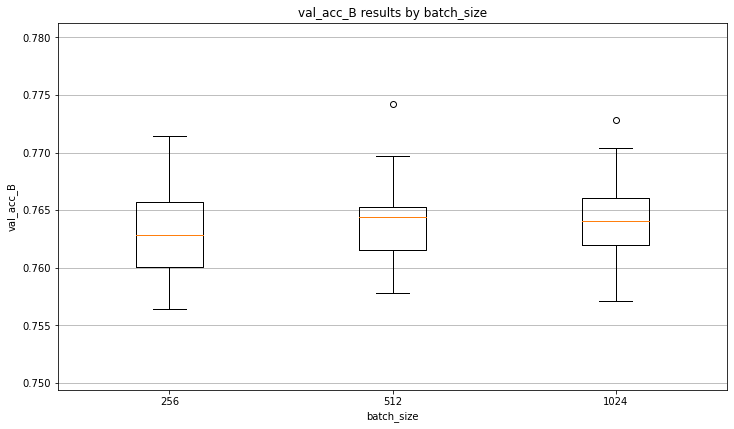

In [ ]:
params_dict = {'batch_size':[256,512,1024]}

results_utils.plotResultsByParameter1(search_results, 
                       params_dict, 
                       params2plot=['batch_size'],
                       metric='val_acc_A')

results_utils.plotResultsByParameter1(search_results, 
                       params_dict, 
                       params2plot=['batch_size'],
                       metric='val_acc_B')

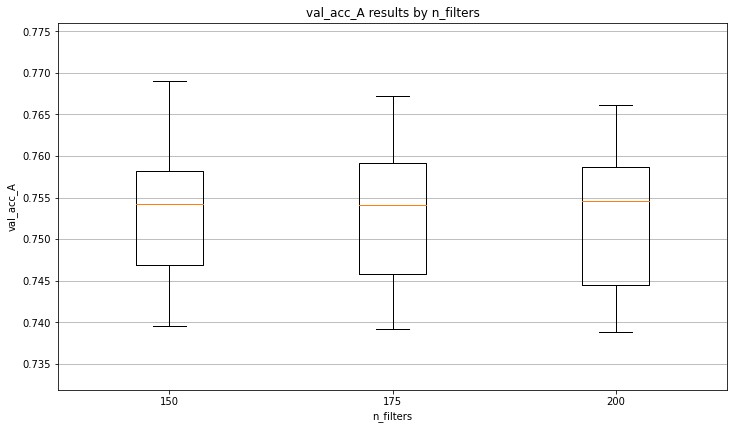

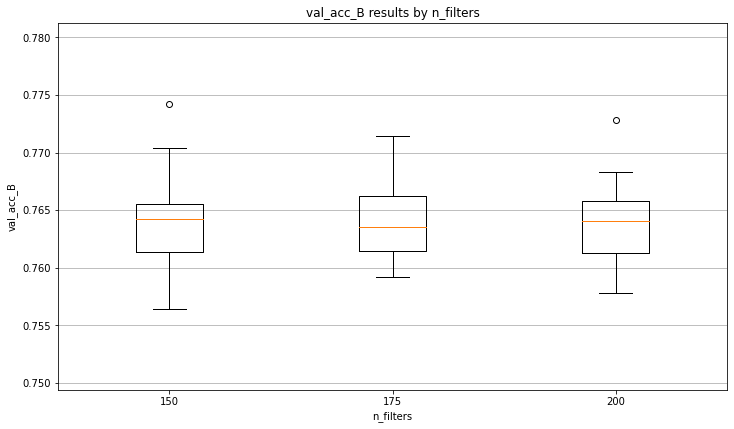

In [ ]:
params_dict = {'n_filters':[150,175,200]}

results_utils.plotResultsByParameter1(search_results, 
                       params_dict, 
                       params2plot=['n_filters'],
                       metric='val_acc_A')

results_utils.plotResultsByParameter1(search_results, 
                       params_dict, 
                       params2plot=['n_filters'],
                       metric='val_acc_B')

### Resumen de los resultados

* combinaciones de kernels sizes: (1,2,3), (2,3,4)
* lstm_units: [150,175]
* dense_layers_sizes: [**(300,100)**, **(400,100)**]
* spatial_dropout: [0.3, **0.5**]
* dense_dropout:[**0.3**]

- Combinaciones (optimizador, cnn_activ, pooling)

  * 'adam-1e-4', 'tanh', 'max'
  * 'adam-1e-4', 'relu', 'max'
  * ''rmsprop-1e-3', 'relu', 'average'

* batch_size: [512,1024]

# Experimentos finales

## Dataset

In [ ]:
X_train, Y_train = dataset_utils.loadEncodedTrainData(embedding_type='FT3',
                                                 encoding_format='EMB-SEQ',
                                                 labels_to_return=['HTA'],
                                                 n_folds=7
                                                 )

FastText 3 - Spanish Unannotated Corpora
Encoding Format: EMB-SEQ

Process complete
5000 train instances retrieved

encodings_dim = (55, 300)


## Espacio de búsqueda

**Parámetros de la arquitectura**

In [ ]:
from itertools import product

from itertools import combinations
from itertools import product

dense_layers_sizes = [(400,100),
                      (300,100)]                    

arch_params = {'kernels_combos':[(1,2,3),(2,3,4)],
              'dense_layers_sizes':dense_layers_sizes,
              'n_filters':[150,175],
              'conv_layers_activation':['tanh','relu'],
              'pooling_method':['max','average'],
              'spatial_dropout':[0.3,0.5],
              'dense_dropout':[0.3]} 

arch_params_keys = arch_params.keys()

arch_params_combos = list(product( *arch_params.values() ))          

#arch_params_combos = [params_combo for params_combo in arch_params_combos if params_combo[-2]>=params_combo[-1]]
print('{} arch_params_combos.'.format(len(arch_params_combos)))   

64 arch_params_combos.


**Parámetros de la arquitectura**

In [ ]:
trainig_params_dict = {'optimizer':['adam-1e-4', 'rmsprop-1e-3'],
                       'batch_size':[512,1024],
                       'max_epochs':[75]}
                        

training_params_keys = trainig_params_dict.keys()
trainig_params_combos = list(product( *trainig_params_dict.values() ))

print('\n{} trainig_params_combos.'.format(len(trainig_params_combos))) 


4 trainig_params_combos.


In [ ]:
temp_search_space = list(product(arch_params_combos, trainig_params_combos))

print('\n{} params combinations in the search_space.'.format(len(temp_search_space))) 


256 params combinations in the search_space.


In [ ]:
useful_opt_activ_pooling_combos = [('adam-1e-4', 'tanh', 'max'),
                                   ('adam-1e-4', 'relu', 'max'),
                                   ('rmsprop-1e-3', 'relu', 'average'),]

In [ ]:
search_space = []
for params_combo in temp_search_space:
  opt_activ_pooling_combo = (params_combo[1][0], params_combo[0][3], params_combo[0][4])
  if opt_activ_pooling_combo in useful_opt_activ_pooling_combos:
    #print(opt_activ_pooling_combo)
    search_space.append(params_combo)

len(search_space)

96

## Escaneo

In [ ]:
results_df = nn_utils.spaceScanner(X_train, Y_train,
                          'HTA',
                          convolutionalNetModel, 
                          search_space,
                          arch_params_keys,
                          training_params_keys,
                          fraction2eval=1,
                          n_folds=7,
                          fitting_attemps=2,
                          stop_threshold=1,
                          partial_CV=False,
                          backup_file='./Results/CNN/HTA/experiments_6f.df',
                          backup_freq=5,
                          save_history_files=True,
                          save_models_as_json=True,
                          save_weights=True)

## Resultados

In [15]:
import pickle
from pandas import DataFrame

with open('./Results/CNN/HTA/experiments_6f.df', 'rb') as file_handler:
  search_results = pickle.load(file_handler)

search_results.shape

(96, 19)

In [17]:
search_results.sort_values(by='val_acc_A', ascending=False).head()

,conf_ID,kernels_combos,dense_layers_sizes,n_filters,conv_layers_activation,pooling_method,spatial_dropout,dense_dropout,optimizer,batch_size,max_epochs,best_epochh,train_acc_A,val_acc_A,min2best,max2best,median2best,train_acc_B,val_acc_B
7,EhlKsruy,"(1, 2, 3)","(400, 100)",150,relu,max,0.5,0.3,adam-1e-4,1024,75,65,0.796268,0.770001,45,66,65,0.774000,0.774802
42,buWKkGpy,"(1, 2, 3)","(300, 100)",175,relu,max,0.5,0.3,adam-1e-4,512,75,33,0.743134,0.769202,31,72,38,0.797102,0.774602
27,QXhDykIQ,"(1, 2, 3)","(300, 100)",150,tanh,max,0.5,0.3,adam-1e-4,1024,75,61,0.778733,0.769003,46,72,56,0.769234,0.772402
39,HqQmJDCM,"(1, 2, 3)","(300, 100)",175,tanh,max,0.5,0.3,adam-1e-4,1024,75,54,0.765467,0.768401,42,64,53,0.768431,0.774200
14,SYXMBoXE,"(1, 2, 3)","(400, 100)",175,tanh,max,0.5,0.3,adam-1e-4,512,75,32,0.774366,0.767599,26,39,32,0.770233,0.773601


In [18]:
search_results.sort_values(by='val_acc_B', ascending=False).head()

,conf_ID,kernels_combos,dense_layers_sizes,n_filters,conv_layers_activation,pooling_method,spatial_dropout,dense_dropout,optimizer,batch_size,max_epochs,best_epochh,train_acc_A,val_acc_A,min2best,max2best,median2best,train_acc_B,val_acc_B
11,xCdcvedN,"(1, 2, 3)","(400, 100)",150,relu,average,0.5,0.3,rmsprop-1e-3,1024,75,65,0.748667,0.758801,53,67,62,0.735401,0.776801
9,YBJbUNaX,"(1, 2, 3)","(400, 100)",150,relu,average,0.3,0.3,rmsprop-1e-3,1024,75,57,0.743867,0.752197,49,74,61,0.742666,0.776399
32,WFNrfnfd,"(1, 2, 3)","(300, 100)",150,relu,average,0.3,0.3,rmsprop-1e-3,512,75,39,0.757500,0.756602,29,64,37,0.754766,0.776202
34,GWVBtYHV,"(1, 2, 3)","(300, 100)",150,relu,average,0.5,0.3,rmsprop-1e-3,512,75,38,0.734133,0.756602,32,57,45,0.758699,0.776001
35,PZKzUveQ,"(1, 2, 3)","(300, 100)",150,relu,average,0.5,0.3,rmsprop-1e-3,1024,75,74,0.757967,0.762598,57,74,70,0.744334,0.775999
